In [ ]:
%load_ext autoreload
%autoreload 2

In [80]:
from __future__ import print_function
from ipywidgets import interact, fixed

import os

import torch
from torchinfo import summary
from torchvision import datasets
import torchvision.transforms as transforms

from umap import UMAP

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split

from models import ocsvm, isolation_forest, lof
from evaluate import avg_auc, avg_cs, custom_scoring
from esvit_swin import extract_features, EsVitPreTrained

### Loading EsVit backbone (Swin-B)

In [73]:
""" checkpoint_path = 'checkpoints/swin_tiny_w7/checkpoint_best.pth'
arch = 'swin_tiny'
cfg = 'esvit/experiments/imagenet/swin/swin_tiny_patch4_window7_224.yaml' """
checkpoint_path = 'checkpoints/swin_base_w14/checkpoint_best.pth'
arch = 'swin_base'
cfg = 'esvit/experiments/imagenet/swin/swin_base_patch4_window14_224.yaml'

In [3]:
model = EsVitPreTrained(cfg, arch, checkpoint_path, num_blocks=4, trainable=False)
model.cuda()
summary(model, input_size=(1, 3, 224, 224))

=> merge config from esvit/experiments/imagenet/swin/swin_base_patch4_window14_224.yaml


/home/prahtz/GoogleDrive/GitHub/esvitomaly/env/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Take key teacher in provided checkpoint dict
Pretrained weights found at checkpoints/swin_base_w14/checkpoint_best.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head_dense.mlp.0.weight', 'head_dense.mlp.0.bias', 'head_dense.mlp.2.weight', 'head_dense.mlp.2.bias', 'head_dense.mlp.4.weight', 'head_dense.mlp.4.bias', 'head_dense.last_layer.weight_g', 'head_dense.last_layer.weight_v', 'head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


Layer (type:depth-idx)                                  Output Shape              Param #
EsVitPreTrained                                         --                        --
├─SwinTransformer: 1                                    --                        --
│    └─ModuleList: 2-1                                  --                        --
│    └─PatchEmbed: 2-2                                  [1, 3136, 128]            --
│    │    └─Conv2d: 3-1                                 [1, 128, 56, 56]          (6,272)
│    │    └─LayerNorm: 3-2                              [1, 3136, 128]            (256)
│    └─Dropout: 2-3                                     [1, 3136, 128]            --
│    └─AdaptiveAvgPool1d: 2-4                           [1, 512, 1]               --
│    └─AdaptiveAvgPool1d: 2-5                           [1, 512, 1]               --
│    └─LayerNorm: 2-6                                   [1, 49, 1024]             (2,048)
│    └─AdaptiveAvgPool1d: 2-7                  

### Preparing the dataset (CIFAR-10)

In [2]:
def plot_images(data):
    class_to_idx = data.class_to_idx
    idx_to_class = {i: c for c, i in class_to_idx.items()}
    @interact(data=fixed(data), idx_to_class=fixed(idx_to_class), x = (0, len(data)-1))
    def plot(data, idx_to_class, x):
        img, label = data[x]
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        for t, m, s in zip(img, mean, std):
            t.mul_(s).add_(m)
        img = transforms.ToPILImage()(img)
        plt.imshow(img)
        plt.title('Class: ' + idx_to_class[label])
        plt.show()


In [3]:
transform = transforms.Compose(
    [transforms.Resize(224, interpolation=3),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
     ])

train_data = datasets.CIFAR10(root='data/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data/', train=False, download=True, transform=transform)

batch_size = 32
num_workers = 4
num_classes = len(train_data.class_to_idx.keys())
data_loader_train = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )
data_loader_test = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False,
    )

plot_images(train_data)


/home/prahtz/GoogleDrive/GitHub/esvitomaly/env/lib/python3.8/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


interactive(children=(IntSlider(value=24999, description='x', max=49999), Output()), _dom_classes=('widget-int…

### Extracting the features from the images

In [89]:
train_feat_path = 'features/' + arch + '/cifar10_train.pkl'
train_labels_path = 'features/' + arch + '/cifar10_train_labels.pkl'
test_feat_path = 'features/' + arch + '/cifar10_test.pkl'
test_labels_path = 'features/' + arch + '/cifar10_test_labels.pkl'

if os.path.exists(train_feat_path):
    print('Loading features...')
    features = torch.load(train_feat_path)
    labels = torch.load(train_labels_path)
    features_test = torch.load(test_feat_path)
    labels_test = torch.load(test_labels_path)
else:
    print('Extracting features...')
    features, labels = extract_features(model, data_loader_train)
    features_test, labels_test = extract_features(model, data_loader_test)
    print('Saving features...')
    torch.save(features, train_feat_path)
    torch.save(features_test, test_feat_path)
    torch.save(labels, train_labels_path)
    torch.save(labels_test, test_labels_path)

Loading features...


### Visualizing the features using t-SNE and UMAP

In [63]:
low_features_TSNE = TSNE(2, learning_rate='auto', init='pca', perplexity=50, random_state=42).fit_transform(features)
low_features_UMAP = UMAP(random_state=42).fit_transform(features)

/home/prahtz/GoogleDrive/GitHub/esvitomaly/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


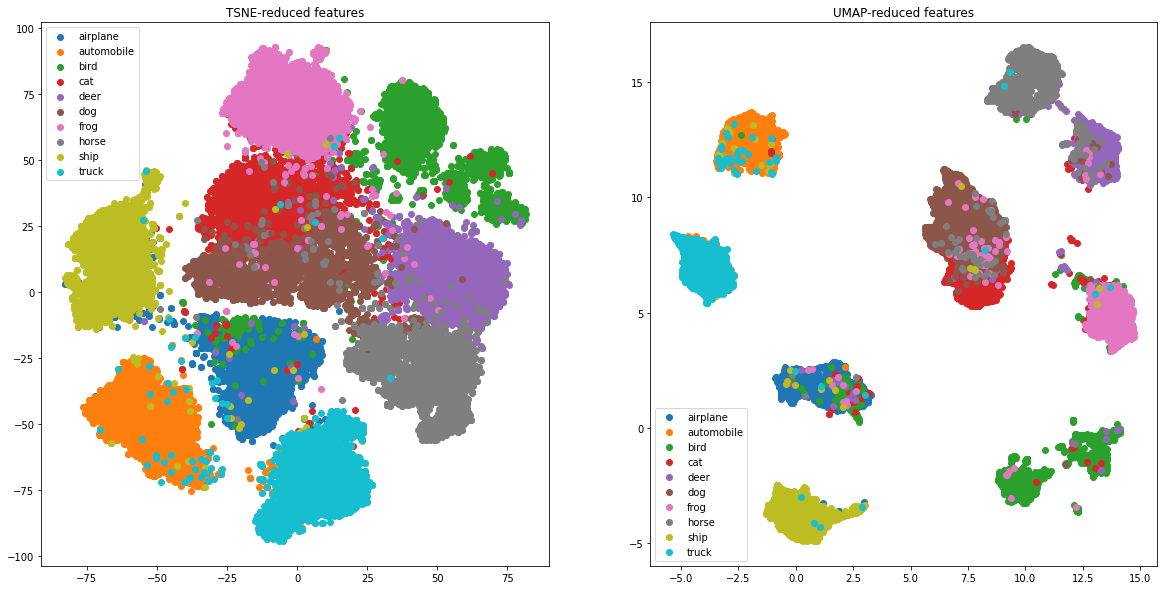

In [66]:
class_to_idx = train_data.class_to_idx
idx_to_class = {i: c for c, i in class_to_idx.items()}
_, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].set_title('TSNE-reduced features')
for i in range(10):
    class_features = low_features_TSNE[labels == i]
    ax[0].scatter(class_features[:,0], class_features[:,1], marker='o', label=idx_to_class[i])
ax[0].legend()

ax[1].set_title('UMAP-reduced features')
for i in range(10):
    class_features = low_features_UMAP[labels == i]
    ax[1].scatter(class_features[:,0], class_features[:,1], marker='o', label=idx_to_class[i])
ax[1].legend()
plt.show()

### Train/Val split

In [18]:
features_train, features_val, labels_train, labels_val = train_test_split(features.numpy(), labels.numpy(), test_size=0.33, random_state=42)

In [19]:
classes = list(range(num_classes))

## Evaluating models using ROC-AUC as metric (research)

### SGD OC-SVM tuning-training-test

In [22]:
best_params = ocsvm.tune_sgd_ocsvm(classes, [features_train, labels_train], [features_val, labels_val], verbose=0)
print(best_params)

Class id 0: best parameters: {'nystroem__gamma': 5.9, 'sgdoneclasssvm__nu': 0.001}
Class id 1: best parameters: {'nystroem__gamma': 6.5, 'sgdoneclasssvm__nu': 0.001}
Class id 2: best parameters: {'nystroem__gamma': 5.7, 'sgdoneclasssvm__nu': 0.01}
Class id 3: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.01}
Class id 4: best parameters: {'nystroem__gamma': 5.6, 'sgdoneclasssvm__nu': 0.001}
Class id 5: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.01}
Class id 6: best parameters: {'nystroem__gamma': 6.3, 'sgdoneclasssvm__nu': 0.001}
Class id 7: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.1}
Class id 8: best parameters: {'nystroem__gamma': 6.5, 'sgdoneclasssvm__nu': 0.01}
Class id 9: best parameters: {'nystroem__gamma': 5.6, 'sgdoneclasssvm__nu': 0.001}
{0: {'nystroem__gamma': 5.9, 'sgdoneclasssvm__nu': 0.001}, 1: {'nystroem__gamma': 6.5, 'sgdoneclasssvm__nu': 0.001}, 2: {'nystroem__gamma': 5.7, 'sgdoneclasssvm__nu': 0.01}, 3:

In [23]:
classifiers = ocsvm.train_sgd_ocsvm(classes, [features, labels], best_params)

In [24]:
score = avg_auc(classifiers, [features_test, labels_test])
print('Average ROC-AUC:', score)

Class: 0 roc-auc:  0.9916431111111111
Class: 1 roc-auc:  0.9969699999999999
Class: 2 roc-auc:  0.9800798888888889
Class: 3 roc-auc:  0.9841433333333334
Class: 4 roc-auc:  0.9848142222222223
Class: 5 roc-auc:  0.9855192222222222
Class: 6 roc-auc:  0.9979931111111111
Class: 7 roc-auc:  0.9945086666666667
Class: 8 roc-auc:  0.99755
Class: 9 roc-auc:  0.997156
Average ROC-AUC: 0.9910377555555556


### Isolation Forest tune-train-test

In [39]:
best_params = isolation_forest.tune_isolation_forest(classes, [features_train, labels_train], [features_val, labels_val])
print(best_params)

Class id 0: best parameters: {'max_samples': 0.2, 'n_estimators': 100}
Class id 1: best parameters: {'max_samples': 0.5, 'n_estimators': 100}
Class id 2: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 3: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 4: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 5: best parameters: {'max_samples': 0.5, 'n_estimators': 100}
Class id 6: best parameters: {'max_samples': 0.5, 'n_estimators': 100}
Class id 7: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 8: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 9: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
{0: {'max_samples': 0.2, 'n_estimators': 100}, 1: {'max_samples': 0.5, 'n_estimators': 100}, 2: {'max_samples': 1.0, 'n_estimators': 100}, 3: {'max_samples': 1.0, 'n_estimators': 100}, 4: {'max_samples': 1.0, 'n_estimators': 100}, 5: {'max_samples': 0.5, 'n_estimators': 100}, 6: {'max_samp

In [41]:
classifiers = isolation_forest.train_isolation_forest(classes, [features, labels], best_params)

In [42]:
score = avg_auc(classifiers, [features_test, labels_test])
print('Average ROC-AUC:', score)

Class: 0 roc-auc:  0.9453351111111112
Class: 1 roc-auc:  0.9907229999999999
Class: 2 roc-auc:  0.8433312222222222
Class: 3 roc-auc:  0.9185386666666667
Class: 4 roc-auc:  0.9609551111111111
Class: 5 roc-auc:  0.9023696666666666
Class: 6 roc-auc:  0.9828585555555556
Class: 7 roc-auc:  0.9858551111111111
Class: 8 roc-auc:  0.9742922222222222
Class: 9 roc-auc:  0.9910186666666667
Average ROC-AUC: 0.9495277333333334


### Local Outlier Factor tune-train-test

In [43]:
best_params = lof.tune_lof(classes, [features_train, labels_train], [features_val, labels_val])
print(best_params)

Class id 0: best parameters: {'n_neighbors': 1000}
Class id 1: best parameters: {'n_neighbors': 1000}
Class id 2: best parameters: {'n_neighbors': 400}
Class id 3: best parameters: {'n_neighbors': 900}
Class id 4: best parameters: {'n_neighbors': 1000}
Class id 5: best parameters: {'n_neighbors': 500}
Class id 6: best parameters: {'n_neighbors': 1000}
Class id 7: best parameters: {'n_neighbors': 1000}
Class id 8: best parameters: {'n_neighbors': 800}
Class id 9: best parameters: {'n_neighbors': 800}
{0: {'n_neighbors': 1000}, 1: {'n_neighbors': 1000}, 2: {'n_neighbors': 400}, 3: {'n_neighbors': 900}, 4: {'n_neighbors': 1000}, 5: {'n_neighbors': 500}, 6: {'n_neighbors': 1000}, 7: {'n_neighbors': 1000}, 8: {'n_neighbors': 800}, 9: {'n_neighbors': 800}}


In [44]:
classifiers = lof.train_lof(classes, [features, labels], best_params)

In [45]:
score = avg_auc(classifiers, [features_test, labels_test])
print('Average ROC-AUC:', score)

Class: 0 roc-auc:  0.9928534444444443
Class: 1 roc-auc:  0.9949773333333334
Class: 2 roc-auc:  0.974827611111111
Class: 3 roc-auc:  0.9825282777777778
Class: 4 roc-auc:  0.9873114444444445
Class: 5 roc-auc:  0.98357
Class: 6 roc-auc:  0.9955488888888889
Class: 7 roc-auc:  0.9794340555555556
Class: 8 roc-auc:  0.9953644444444444
Class: 9 roc-auc:  0.9972805555555556
Average ROC-AUC: 0.9883696055555555


## Evaluating models using a custom metric (confusion matrix based cost model + sample weight + best threshold selection)

### Cost model

In [46]:
cost_model = {'tp':0, 'tn':0, 'fp':0.1, 'fn':1}
scoring = make_scorer(custom_scoring, greater_is_better=False, needs_threshold=True, cost_model=cost_model, sample_weight='balanced')

### SGD OC-SVM tuning-training-test

In [47]:
best_params = ocsvm.tune_sgd_ocsvm(classes, [features_train, labels_train], [features_val, labels_val], scoring=scoring)
print(best_params)

Class id 0: best parameters: {'nystroem__gamma': 5.8, 'sgdoneclasssvm__nu': 0.001}
Class id 1: best parameters: {'nystroem__gamma': 6.5, 'sgdoneclasssvm__nu': 0.01}
Class id 2: best parameters: {'nystroem__gamma': 5.7, 'sgdoneclasssvm__nu': 0.01}
Class id 3: best parameters: {'nystroem__gamma': 5.6, 'sgdoneclasssvm__nu': 0.01}
Class id 4: best parameters: {'nystroem__gamma': 5.8, 'sgdoneclasssvm__nu': 0.5}
Class id 5: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.01}
Class id 6: best parameters: {'nystroem__gamma': 5.9, 'sgdoneclasssvm__nu': 0.001}
Class id 7: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.1}
Class id 8: best parameters: {'nystroem__gamma': 6.0, 'sgdoneclasssvm__nu': 0.5}
Class id 9: best parameters: {'nystroem__gamma': 5.5, 'sgdoneclasssvm__nu': 0.1}
{0: {'nystroem__gamma': 5.8, 'sgdoneclasssvm__nu': 0.001}, 1: {'nystroem__gamma': 6.5, 'sgdoneclasssvm__nu': 0.01}, 2: {'nystroem__gamma': 5.7, 'sgdoneclasssvm__nu': 0.01}, 3: {'nyst

In [48]:
classifiers = ocsvm.train_sgd_ocsvm(classes, [features, labels], best_params)

In [49]:
score = avg_cs(classifiers, [features_test.numpy(), labels_test.numpy()], cost_model)
print('Average Cost:', score)

Class: 0 custom score:  78.2
Class: 1 custom score:  53.3
Class: 2 custom score:  123.9
Class: 3 custom score:  111.0
Class: 4 custom score:  113.5
Class: 5 custom score:  113.4
Class: 6 custom score:  44.400000000000006
Class: 7 custom score:  69.2
Class: 8 custom score:  37.400000000000006
Class: 9 custom score:  44.7
Average Cost: 78.9


### Isolation Forest tune-train-test

In [55]:
best_params = isolation_forest.tune_isolation_forest(classes, [features_train, labels_train], [features_val, labels_val], scoring=scoring)
print(best_params)

Class id 0: best parameters: {'max_samples': 0.2, 'n_estimators': 100}
Class id 1: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 2: best parameters: {'max_samples': 'auto', 'n_estimators': 100}
Class id 3: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 4: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 5: best parameters: {'max_samples': 0.5, 'n_estimators': 100}
Class id 6: best parameters: {'max_samples': 0.5, 'n_estimators': 100}
Class id 7: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 8: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
Class id 9: best parameters: {'max_samples': 1.0, 'n_estimators': 100}
{0: {'max_samples': 0.2, 'n_estimators': 100}, 1: {'max_samples': 1.0, 'n_estimators': 100}, 2: {'max_samples': 'auto', 'n_estimators': 100}, 3: {'max_samples': 1.0, 'n_estimators': 100}, 4: {'max_samples': 1.0, 'n_estimators': 100}, 5: {'max_samples': 0.5, 'n_estimators': 100}, 6: {'ma

In [56]:
classifiers = isolation_forest.train_isolation_forest(classes, [features, labels], best_params)

In [61]:
score = avg_cs(classifiers, [features_test.numpy(), labels_test.numpy()], cost_model)
print('Average Cost:', score)

Class: 0 custom score:  229.4
Class: 1 custom score:  70.4
Class: 2 custom score:  537.4000000000001
Class: 3 custom score:  300.20000000000005
Class: 4 custom score:  182.10000000000002
Class: 5 custom score:  331.70000000000005
Class: 6 custom score:  112.4
Class: 7 custom score:  92.9
Class: 8 custom score:  155.5
Class: 9 custom score:  77.5
Average Cost: 208.95


### Local Outlier Factor tune-train-test

In [67]:
best_params = lof.tune_lof(classes, [features_train, labels_train], [features_val, labels_val], scoring=scoring)
print(best_params)

Class id 0: best parameters: {'n_neighbors': 1000}
Class id 1: best parameters: {'n_neighbors': 300}
Class id 2: best parameters: {'n_neighbors': 300}
Class id 3: best parameters: {'n_neighbors': 700}
Class id 4: best parameters: {'n_neighbors': 1000}
Class id 5: best parameters: {'n_neighbors': 700}
Class id 6: best parameters: {'n_neighbors': 1000}
Class id 7: best parameters: {'n_neighbors': 1000}
Class id 8: best parameters: {'n_neighbors': 900}
Class id 9: best parameters: {'n_neighbors': 900}
{0: {'n_neighbors': 1000}, 1: {'n_neighbors': 300}, 2: {'n_neighbors': 300}, 3: {'n_neighbors': 700}, 4: {'n_neighbors': 1000}, 5: {'n_neighbors': 700}, 6: {'n_neighbors': 1000}, 7: {'n_neighbors': 1000}, 8: {'n_neighbors': 900}, 9: {'n_neighbors': 900}}


In [68]:
classifiers = lof.train_lof(classes, [features, labels], best_params)

In [69]:
score = avg_cs(classifiers, [features_test.numpy(), labels_test.numpy()], cost_model)
print('Average Cost:', score)

Class: 0 custom score:  74.30000000000001
Class: 1 custom score:  96.0
Class: 2 custom score:  185.3
Class: 3 custom score:  120.4
Class: 4 custom score:  106.4
Class: 5 custom score:  108.30000000000001
Class: 6 custom score:  65.6
Class: 7 custom score:  129.3
Class: 8 custom score:  60.6
Class: 9 custom score:  40.900000000000006
Average Cost: 98.71000000000001
